In [1]:

# coding: utf-8

# In[1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Reshape, Convolution1D, BatchNormalization, UpSampling1D, Activation, RepeatVector, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras import optimizers
import seaborn as sns
from keras.initializers import random_uniform
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import linregress
import itertools
from keras import backend as K

from scipy.fftpack import fft
from scipy import signal
import matplotlib



GPU_NUM = 0

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(GPU_NUM)
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""


import tensorflow as tf
tf.set_random_seed(1989)
np.random.seed(1989)

try:
    K.clear_session()
except:
    pass

Using TensorFlow backend.


In [2]:
df_N2 = pd.read_excel('../input_Pd/(2018-08-16 21_34_57)Pdset; N2 purging overnight.xlsx')
df_2_5 = pd.read_excel('../input_Pd/(2018-08-17 10_08_57)PdH2 2.5ppm purging 5 hr.xlsx')
df_10 = pd.read_excel('../input_Pd/(2018-08-17 15_09_42)set; H2 10 ppm purging 6 hr.xlsx')

In [3]:
df = pd.concat([df_N2, df_2_5, df_10]).reset_index(drop=True)

df.head()
# # Prepare tranining set for CNN1D

# ### Sample sequences

,스캔,시간,sample1,sample2,sample3,sample4
0,1,2018-08-16 21:34:57:163,31.379456,33.894596,32.528053,34.315109
1,2,2018-08-16 21:34:58:159,31.376764,33.894596,32.527925,34.315494
2,3,2018-08-16 21:34:59:159,31.375995,33.893570,32.528310,34.316135
3,4,2018-08-16 21:35:00:159,31.375866,33.894339,32.527541,34.316135
4,5,2018-08-16 21:35:01:159,31.376251,33.893955,32.528694,34.315750


45127 63073 84941


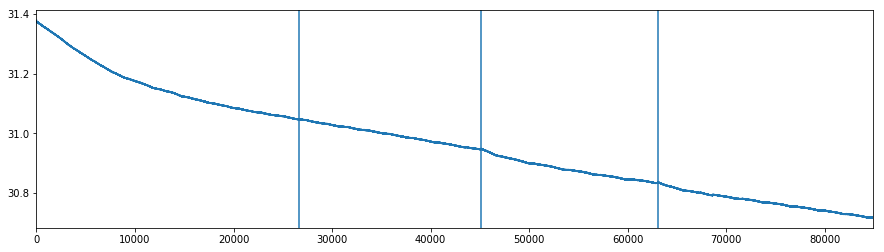

In [4]:
# In[7]:


df.columns = ['scan', 'time', 'Pd1', 'Pd2', 'Pd3', 'Pd4']

metal = 'Pd1'
delta = 2048

time_1 = df_N2.shape[0]
time_2 = time_1 + df_2_5.shape[0]
time_3 = time_2 + df_10.shape[0]
print(time_1, time_2, time_3)

import os

if os.path.exists('./{}_figure_data/'.format(metal)):
    pass
else:
    os.mkdir('./{}_figure_data/'.format(metal))

plt.figure(figsize=(15, 4))
df[metal].plot()

plt.axvline(time_1)
plt.axvline(time_2)
plt.axvline(time_1 - 18484)

# In[9]:


def delete_slope(x):
    t = np.arange(0.0, x.size)
    return x - np.poly1d(np.polyfit(t, x, 1))(t)
plt.rcParams.update({'font.size': 18})

# plt.ylabel('Resistance')
# plt.xlabel('Count')


In [5]:
threshold = 18484

signal = df[metal][time_1 - threshold:time_1 -100].values

length = signal.shape[0]
print(length)

i = 0
signalall = [[],[]]
ii = 0
indexes = []
while (i < length):
    number = 250 #np.random.randint(300,400)
    indexes.append(i)
    for j in range(number):
        indexes.append(i+j)
        if (i + j + delta < length):
            sliced = signal[i + j: i + j + delta]
            signalall[ii%2].append(sliced)
    i = i + j + delta
    ii += 1

normal_1 = pd.DataFrame(signalall[0]).values
normal_2 = pd.DataFrame(signalall[1]).values
print(normal_1.shape, normal_2.shape)

18384
(1000, 2048) (1000, 2048)


In [6]:
np.random.shuffle(normal_1)
np.random.shuffle(normal_2)

normal_1 = normal_1[:1000]
normal_2 = normal_2[:1000]

In [7]:
np.random.seed(0)

# normal = []
# for i in range(time_1-18484, time_1 - delta-100):
#     start = i
#     end = start + delta
#     temp_array = df[metal][start:end].values
#     normal.append(temp_array.flatten())
# normal = np.array(normal)

anomaly_1 = []
for i in range(time_1 + 200, time_2 - 2000 - delta-100):
    start = i
    end = start + delta
    temp_array = df[metal][start:end].values
    anomaly_1.append(temp_array.flatten())
anomaly_1 = np.array(anomaly_1)

anomaly_2 = []
for i in range(time_2 + 200, time_3 - 2000 - delta-100):
    start = i
    end = start + delta
    temp_array = df[metal][start:end].values
    anomaly_2.append(temp_array.flatten())
anomaly_2 = np.array(anomaly_2)

In [8]:
def remove_slope_info(sequence):
    x = np.arange(delta)
    y = sequence
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    slope_information = slope * x + intercept
    
    new_sequence = sequence - slope_information
    return new_sequence
def delete_slope(x):
    t = np.arange(0.0, x.size)
    return x - np.poly1d(np.polyfit(t, x, 1))(t)

for i in range(normal_1.shape[0]):
    normal_1[i] = delete_slope(normal_1[i])

for i in range(normal_2.shape[0]):
    normal_2[i] = delete_slope(normal_2[i])
    
for i in range(anomaly_1.shape[0]):
    anomaly_1[i] = delete_slope(anomaly_1[i])

for i in range(anomaly_2.shape[0]):
    anomaly_2[i] = delete_slope(anomaly_2[i])

In [9]:
# In[15]:


num_normal_1 = normal_1.shape[0]


# In[16]:


np.random.shuffle(anomaly_1)
np.random.shuffle(anomaly_2)
anomaly_1 = anomaly_1[:num_normal_1]
anomaly_2 = anomaly_2[:num_normal_1]


# In[17]:


print(normal_1.shape, normal_2.shape)
print(anomaly_1.shape, anomaly_2.shape)


# In[18]:


def make_target_label(size, class_name):
    label = []
    for i in range(size):
        label.append(class_name)
    return label

normal_1_label = make_target_label(normal_1.shape[0], 0)
normal_2_label = make_target_label(normal_2.shape[0], 1)
anomaly_1_label = make_target_label(anomaly_1.shape[0], 2)
anomaly_2_label = make_target_label(anomaly_2.shape[0], 3)

(1000, 2048) (1000, 2048)
(1000, 2048) (1000, 2048)


In [10]:
print(normal_1.shape, normal_2.shape)
print(anomaly_1.shape, anomaly_2.shape)

(1000, 2048) (1000, 2048)
(1000, 2048) (1000, 2048)


In [11]:
X_train = normal_1
X_test = np.concatenate([normal_1, normal_2, anomaly_1, anomaly_2])
y_test = np.concatenate([normal_1_label, normal_2_label, anomaly_1_label, anomaly_2_label])

In [12]:
X_train = np.transpose(X_train[:, :, np.newaxis], (0, 2, 1))
X_test = np.transpose(X_test[:, :, np.newaxis], (0, 2, 1))

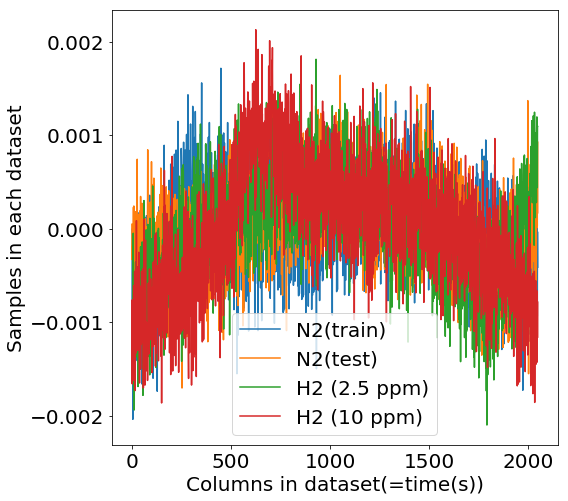

In [13]:
# In[23]:


plt.figure(figsize=(8, 8))
plt.plot(normal_1[np.random.randint(1000)])
plt.plot(normal_2[np.random.randint(1000)])
plt.plot(anomaly_1[np.random.randint(1000)])
plt.plot(anomaly_2[np.random.randint(1000)])
plt.legend(['N2(train)', 'N2(test)', 'H2 (2.5 ppm)', 'H2 (10 ppm)'], fontsize=20)
plt.xlabel('Columns in dataset(=time(s))', fontsize=20)
plt.ylabel('Samples in each dataset', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [14]:
from keras.layers import LeakyReLU

class LeakyReLU(LeakyReLU):
    def __init__(self, **kwargs):
        self.__name__ = "LeakyReLU"
        super(LeakyReLU, self).__init__(**kwargs)


In [15]:
from keras.layers import Input, LSTM, RepeatVector, CuDNNLSTM, CuDNNGRU, TimeDistributed, BatchNormalization, Flatten
from keras.models import Model

input_dim = X_train.shape[2]

inputs = Input(shape=(1, input_dim))
batch = BatchNormalization()(inputs)
encoded_1 = (CuDNNGRU(1024, return_sequences=True))(batch)
encoded_2 = (CuDNNGRU(512, return_sequences=False))(encoded_1)

encoded_2 = Dense(256, activation='relu')(encoded_2)

decoded_1 = RepeatVector(1)(encoded_2)

decoded_1 = (CuDNNGRU(512, return_sequences=True))(decoded_1)
decoded_2 = (CuDNNGRU(1024, return_sequences=True))(decoded_1)
decoded_3 = (CuDNNGRU(2048, return_sequences=True))(decoded_2)


autoencoder = Model(inputs, decoded_3)
autoencoder.compile(optimizer='Adam',
                   loss='mean_squared_error')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 2048)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 2048)           8192      
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 1, 1024)           9443328   
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 512)               2362368   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 256)            0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 1, 512)            1182720   
__________

In [16]:
nb_epoch = 2000
batch_size = 128


filepath='./RNN_autoencoder_{}_delta_{}_epoch_{}.h5'.format(metal, delta, nb_epoch)

#myoptim = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=0.0001, decay=0.01)
checkpointer = ModelCheckpoint(filepath=filepath,
                              verbose=0,
                              save_best_only=True)
reducerl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, min_lr=1e-6)
# tensorboard = TensorBoard(log_dir='./logs',
#                          histogram_freq=0,
#                          write_graph=True,
#                          write_images=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=60)

history = autoencoder.fit(X_train, X_train,
                     epochs=nb_epoch,
                     batch_size=batch_size,
                     shuffle=True,
                     validation_data=(np.transpose(normal_2[:, :, np.newaxis], (0, 2, 1)), np.transpose(normal_2[:, :, np.newaxis], (0, 2, 1))),
                     verbose=1,
                     callbacks=[checkpointer, earlystopping, reducerl]).history

Train on 1000 samples, validate on 1000 samples
Epoch 1/2000
1000/1000 [==============================] - 7s 7ms/step - loss: 3.3177e-07 - val_loss: 3.1950e-07
Epoch 2/2000
1000/1000 [==============================] - 0s 348us/step - loss: 3.2079e-07 - val_loss: 3.3717e-07
Epoch 3/2000
1000/1000 [==============================] - 0s 358us/step - loss: 3.1781e-07 - val_loss: 3.1254e-07
Epoch 4/2000
1000/1000 [==============================] - 0s 358us/step - loss: 3.1736e-07 - val_loss: 3.1252e-07
Epoch 5/2000
1000/1000 [==============================] - 0s 358us/step - loss: 3.1605e-07 - val_loss: 3.1979e-07
Epoch 6/2000
1000/1000 [==============================] - 0s 348us/step - loss: 3.1617e-07 - val_loss: 3.1569e-07
Epoch 7/2000
1000/1000 [==============================] - 0s 351us/step - loss: 3.1587e-07 - val_loss: 3.1460e-07
Epoch 8/2000
1000/1000 [==============================] - 0s 365us/step - loss: 3.1562e-07 - val_loss: 3.1742e-07
Epoch 9/2000
1000/1000 [==================

In [17]:
filepath='./RNN_autoencoder_{}_delta_{}_epoch_{}.h5'.format(metal, delta, nb_epoch)
autoencoder.load_weights(filepath=filepath)

In [18]:
%%time
predictions = autoencoder.predict(X_test)

CPU times: user 764 ms, sys: 228 ms, total: 992 ms
Wall time: 701 ms


In [19]:
mse = np.mean(np.mean(np.power((X_test -predictions), 2), axis=1), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

normal_1_error_df = error_df[(error_df['true_class'] == 0)]
normal_2_error_df = error_df[(error_df['true_class'] == 1)]
anomaly_1_df = error_df[(error_df['true_class'] == 2)]
anomaly_2_df = error_df[(error_df['true_class'] == 3)]

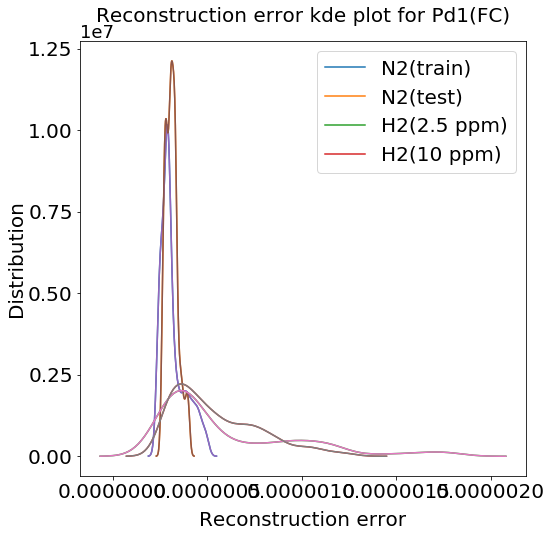

In [20]:
# plt.rcParams['font.family'] = 'Calibri'
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
font_size= 20
label_font = {
    'size':font_size
}

g = sns.kdeplot(normal_1_error_df.reconstruction_error, ax=ax)
g = sns.kdeplot(normal_2_error_df.reconstruction_error, ax=ax)
g = sns.kdeplot(anomaly_1_df.reconstruction_error, ax=ax)
g = sns.kdeplot(anomaly_2_df.reconstruction_error, ax=ax)

ax.set_title('Reconstruction error kde plot for {}(FC)'.format(metal), y=1.03, fontsize=font_size)
# ax[1].legend(['Normal_1(train)', 'Abnormal_1', 'Abnormal_2', 'N2', 'H2_2.5', 'H2_5'])
ax.legend(['N2(train)', 'N2(test)', 'H2(2.5 ppm)', 'H2(10 ppm)'], fontsize=font_size)
ax.set_xlabel('Reconstruction error', fontdict=label_font, y=1)
ax.set_ylabel('Distribution', fontdict=label_font)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=6)
ax.xaxis.set_label_coords(0.5, -0.08)
ax.yaxis.set_label_coords(-0.12, 0.5)
# ax.set_xscale('log')
# ax.set_ylim(0, 200)
# ax.set_xlim(0, 1)
# plt.savefig('./Error_kde/Error_kde_FC_{}.png'.format(metal))
# plt.show()

N2_train_kde_data = g.get_lines()[0].get_data()
N2_test_data = g.get_lines()[1].get_data()
H2_2_5_kde_data = g.get_lines()[2].get_data()
H2_10_kde_data = g.get_lines()[3].get_data()

plt.plot(N2_train_kde_data[0], N2_train_kde_data[1])
plt.plot(N2_test_data[0], N2_test_data[1])
plt.plot(H2_2_5_kde_data[0], H2_2_5_kde_data[1])
plt.plot(H2_10_kde_data[0], H2_10_kde_data[1])

error_kde_data = pd.DataFrame()
error_kde_data['x_N2_train'] = N2_train_kde_data[0]
error_kde_data['y_N2_train'] = N2_train_kde_data[1]
error_kde_data['x_N2_valid'] = N2_test_data[0]
error_kde_data['y_N2_valid'] = N2_test_data[1]
error_kde_data['x_H2_2.5'] = H2_2_5_kde_data[0]
error_kde_data['y_H2_2.5'] = H2_2_5_kde_data[1]
error_kde_data['x_H2_10'] = H2_10_kde_data[0]
error_kde_data['y_H2_10'] = H2_10_kde_data[1]
error_kde_data.to_csv('./{}_figure_data/{}_RETYPE_Error_kde_FC.csv'.format(metal, metal), index=False)

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_roc_auc_score(data_N, data_A):
    data_all = np.concatenate([data_N, data_A])
    true_class = []
    for i in range(2000):
        if i < 1000:
            true_class.append(0)
        else:
            true_class.append(1)

    temp_roc_score = roc_auc_score(true_class, data_all)
    return temp_roc_score


true_class = []
for i in range(2000):
    if i < 1000:
        true_class.append(0)
    else:
        true_class.append(1)

/home/youhanlee/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


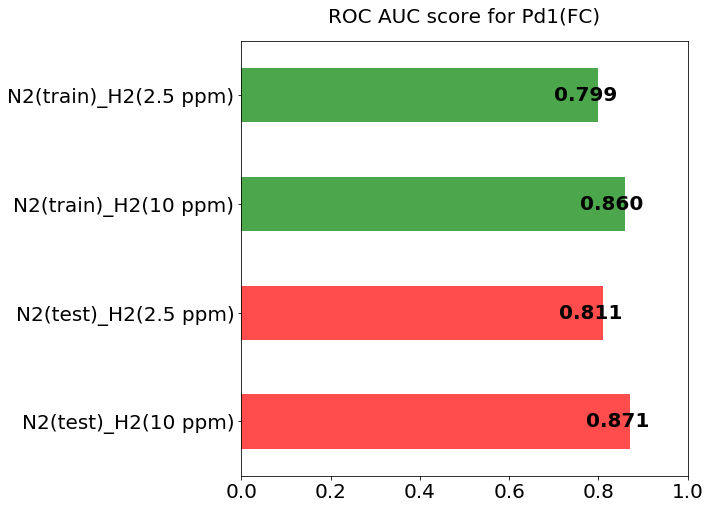

In [22]:
auc_n1_a1 = calculate_roc_auc_score(normal_1_error_df.reconstruction_error.values, anomaly_1_df.reconstruction_error.values)
auc_n1_a2 = calculate_roc_auc_score(normal_1_error_df.reconstruction_error.values, anomaly_2_df.reconstruction_error.values)
auc_n2_a1 = calculate_roc_auc_score(normal_2_error_df.reconstruction_error.values, anomaly_1_df.reconstruction_error.values)
auc_n2_a2 = calculate_roc_auc_score(normal_2_error_df.reconstruction_error.values, anomaly_2_df.reconstruction_error.values)

roc_df = pd.DataFrame()

roc_df.loc[0, 'case'] = 'N2(train)_H2(2.5 ppm)'
roc_df.loc[1, 'case'] = 'N2(train)_H2(10 ppm)'
roc_df.loc[2, 'case'] = 'N2(test)_H2(2.5 ppm)'
roc_df.loc[3, 'case'] = 'N2(test)_H2(10 ppm)'

roc_df.loc[0, 'auc'] = auc_n1_a1
roc_df.loc[1, 'auc'] = auc_n1_a2
roc_df.loc[2, 'auc'] = auc_n2_a1
roc_df.loc[3, 'auc'] = auc_n2_a2


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
x = np.arange(4)
roc_df.plot.barh(x='case', y='auc', legend=False, colors=['g', 'g', 'r', 'r'], ax=ax, alpha=0.7)
plt.gca().invert_yaxis()
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('')
ax.set_title('ROC AUC score for {}(FC)'.format(metal), y=1.03, fontsize=font_size)
ax.set_xlim([0, 1])

for i, v in enumerate(roc_df['auc']):
    plt.text(v-0.1, i, "{:.3f}".format(v), color='black', va='center', fontweight='bold', fontsize=20)
    

# plt.savefig('./AUC_bar/AUC_bar_Freq_FC_{}.png'.format(metal))
# plt.show()

# AUC score

In [23]:
data_N, data_A = normal_1_error_df.reconstruction_error.values, anomaly_1_df.reconstruction_error.values
data_all = np.concatenate([data_N, data_A])
fpr_n1_a1, tpr_n1_a1, _ = roc_curve(true_class, data_all)
roc_n1_a1 = roc_auc_score(true_class, data_all)


data_N, data_A = normal_1_error_df.reconstruction_error.values, anomaly_2_df.reconstruction_error.values
data_all = np.concatenate([data_N, data_A])
fpr_n1_a2, tpr_n1_a2, _ = roc_curve(true_class, data_all)
roc_n1_a2 = roc_auc_score(true_class, data_all)


data_N, data_A = normal_2_error_df.reconstruction_error.values, anomaly_1_df.reconstruction_error.values
data_all = np.concatenate([data_N, data_A])
fpr_n2_a1, tpr_n2_a1, _ = roc_curve(true_class, data_all)
roc_n2_a1 = roc_auc_score(true_class, data_all)


data_N, data_A = normal_2_error_df.reconstruction_error.values, anomaly_2_df.reconstruction_error.values
data_all = np.concatenate([data_N, data_A])
fpr_n2_a2, tpr_n2_a2, _ = roc_curve(true_class, data_all)
roc_n2_a2 = roc_auc_score(true_class, data_all)

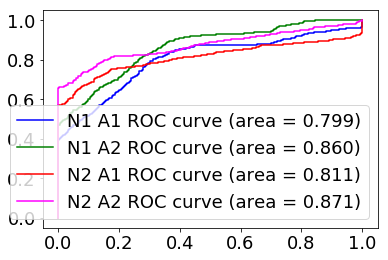

In [24]:
plt.plot(fpr_n1_a1, tpr_n1_a1, color='blue', label='N1 A1 ROC curve (area = {:.3f})'.format(roc_n1_a1))
plt.plot(fpr_n1_a2, tpr_n1_a2, color='green', label='N1 A2 ROC curve (area = {:.3f})'.format(roc_n1_a2))
plt.plot(fpr_n2_a1, tpr_n2_a1, color='red', label='N2 A1 ROC curve (area = {:.3f})'.format(roc_n2_a1))
plt.plot(fpr_n2_a2, tpr_n2_a2, color='magenta', label='N2 A2 ROC curve (area = {:.3f})'.format(roc_n2_a2))

plt.legend(loc='lower right')

In [25]:
np.savetxt("./{}_figure_data/{}_RETYPE_roc_curve_fpr_n1_a1.csv".format(metal, metal), fpr_n1_a1, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_roc_curve_fpr_n1_a2.csv".format(metal, metal), fpr_n1_a2, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_roc_curve_fpr_n2_a1.csv".format(metal, metal), fpr_n2_a1, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_roc_curve_fpr_n2_a2.csv".format(metal, metal), fpr_n2_a2, delimiter=",")

np.savetxt("./{}_figure_data/{}_RETYPE_roc_curve_tpr_n1_a1.csv".format(metal, metal), tpr_n1_a1, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_roc_curve_tpr_n1_a2.csv".format(metal, metal), tpr_n1_a2, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_roc_curve_tpr_n2_a1.csv".format(metal, metal), tpr_n2_a1, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_roc_curve_tpr_n2_a2.csv".format(metal, metal), tpr_n2_a2, delimiter=",")

# TSNE

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [27]:
latent_space = Model(inputs=inputs, outputs=encoded_2)

latent_normal_1 = latent_space.predict(np.transpose(normal_1[:1000][:, :, np.newaxis], (0, 2, 1)))
latent_normal_2 = latent_space.predict(np.transpose(normal_2[:1000][:, :, np.newaxis], (0, 2, 1)))
latent_abnormal_1 = latent_space.predict(np.transpose(anomaly_1[:1000][:, :, np.newaxis], (0, 2, 1)))
latent_abnormal_2 = latent_space.predict(np.transpose(anomaly_2[:1000][:, :, np.newaxis], (0, 2, 1)))

latent_all = np.concatenate([latent_normal_1, latent_normal_2, latent_abnormal_1, latent_abnormal_2])

In [28]:
X_std = StandardScaler().fit_transform(latent_all)

In [29]:
tsne = TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(X_std) 

No handles with labels found to put in legend.


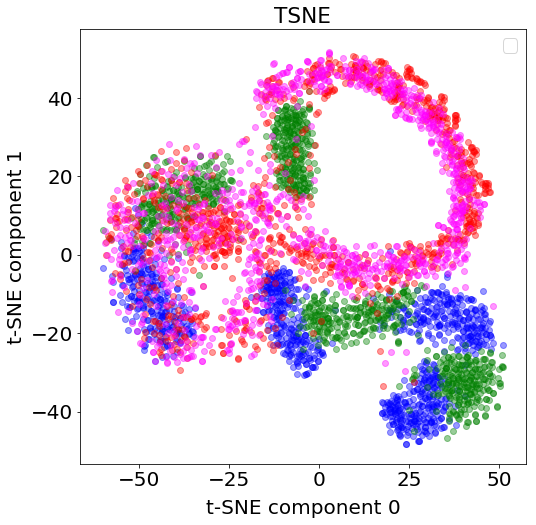

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
font_size= 20
label_font = {
    'size':font_size
}

alpha = 0.4
ax.scatter(tsne_results[:1000, 0], tsne_results[:1000, 1], color='b', alpha=alpha)
ax.scatter(tsne_results[1000:2000, 0], tsne_results[1000:2000, 1], color='green',  alpha=alpha)
ax.scatter(tsne_results[2000:3000, 0], tsne_results[2000:3000, 1], color='red', alpha=alpha)
ax.scatter(tsne_results[3000:4000, 0], tsne_results[3000:4000, 1], color='magenta', alpha=alpha)
ax.set_title('TSNE')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=6)
ax.xaxis.set_label_coords(0.5, -0.08)
ax.yaxis.set_label_coords(-0.12, 0.5)
ax.legend(['N2(train)', 'N2(test)', 'H2(2.5 ppm)', 'H2(10 ppm)'], fontsize=font_size)
ax.set_xlabel('t-SNE component 0', fontdict=label_font)
ax.set_ylabel('t-SNE component 1', fontdict=label_font)
# plt.savefig('./TSNE/tsne_{}.png'.format(metal))
plt.legend()

In [31]:
np.savetxt("./{}_figure_data/{}_RETYPE_tsne_results.csv".format(metal, metal), tsne_results, delimiter=",")

In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [33]:
data_N, data_A = normal_1_error_df.reconstruction_error.values, anomaly_1_df.reconstruction_error.values
data_all = np.concatenate([data_N, data_A])
precision_n1_a1, recall_n1_a1, _ = precision_recall_curve(true_class, data_all)
average_precision_n1_a1 = average_precision_score(true_class, data_all)


data_N, data_A = normal_1_error_df.reconstruction_error.values, anomaly_2_df.reconstruction_error.values
data_all = np.concatenate([data_N, data_A])
precision_n1_a2, recall_n1_a2, _ = precision_recall_curve(true_class, data_all)
average_precision_n1_a2 = average_precision_score(true_class, data_all)


data_N, data_A = normal_2_error_df.reconstruction_error.values, anomaly_1_df.reconstruction_error.values
data_all = np.concatenate([data_N, data_A])
precision_n2_a1, recall_n2_a1, _ = precision_recall_curve(true_class, data_all)
average_precision_n2_a1 = average_precision_score(true_class, data_all)


data_N, data_A = normal_2_error_df.reconstruction_error.values, anomaly_2_df.reconstruction_error.values
data_all = np.concatenate([data_N, data_A])
precision_n2_a2, recall_n2_a2, _ = precision_recall_curve(true_class, data_all)
average_precision_n2_a2 = average_precision_score(true_class, data_all)

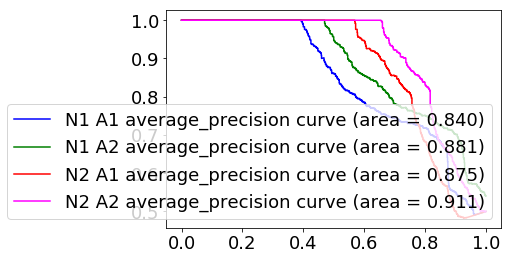

In [34]:
plt.plot(recall_n1_a1, precision_n1_a1, color='b', label='N1 A1 average_precision curve (area = {:.3f})'.format(average_precision_n1_a1))
plt.plot(recall_n1_a2, precision_n1_a2, color='green', label='N1 A2 average_precision curve (area = {:.3f})'.format(average_precision_n1_a2))
plt.plot(recall_n2_a1, precision_n2_a1, color='red', label='N2 A1 average_precision curve (area = {:.3f})'.format(average_precision_n2_a1))
plt.plot(recall_n2_a2, precision_n2_a2, color='magenta', label='N2 A2 average_precision curve (area = {:.3f})'.format(average_precision_n2_a2))

plt.legend(loc='lower right')

In [35]:
np.savetxt("./{}_figure_data/{}_RETYPE_precision_recall_curve_precision_n1_a1.csv".format(metal, metal), precision_n1_a1, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_precision_recall_curve_precision_n1_a2.csv".format(metal, metal), precision_n1_a2, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_precision_recall_curve_precision_n2_a1.csv".format(metal, metal), precision_n2_a1, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_precision_recall_curve_precision_n2_a2.csv".format(metal, metal), precision_n2_a2, delimiter=",")

np.savetxt("./{}_figure_data/{}_RETYPE_precision_recall_curve_recall_n1_a1.csv".format(metal, metal), recall_n1_a1, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_precision_recall_curve_recall_n1_a2.csv".format(metal, metal), recall_n1_a2, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_precision_recall_curve_recall_n2_a1.csv".format(metal, metal), recall_n2_a1, delimiter=",")
np.savetxt("./{}_figure_data/{}_RETYPE_precision_recall_curve_recall_n2_a2.csv".format(metal, metal), recall_n2_a2, delimiter=",")

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix', filename=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    plt.grid(False)
    plt.clim(0, 1)

    fmt = '.2f' if normalize else 'd'
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=20)

#     plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.savefig(filename)
    plt.show()

In [37]:
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix, f1_score, precision_recall_curve, accuracy_score # for evaluation
from sklearn.metrics import average_precision_score, roc_auc_score, classification_report

In [38]:
y_true = []
for i in range(2000):
    if i < 1000:
        y_true.append(0)
    else:
        y_true.append(1)
        
y_true = np.array(y_true)

100%|█████████▉| 99993/100000 [04:19<00:00, 404.95it/s]/home/youhanlee/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/youhanlee/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 100000/100000 [04:19<00:00, 385.25it/s]


#################### Pd1
Normalized confusion matrix


<Figure size 720x576 with 0 Axes>

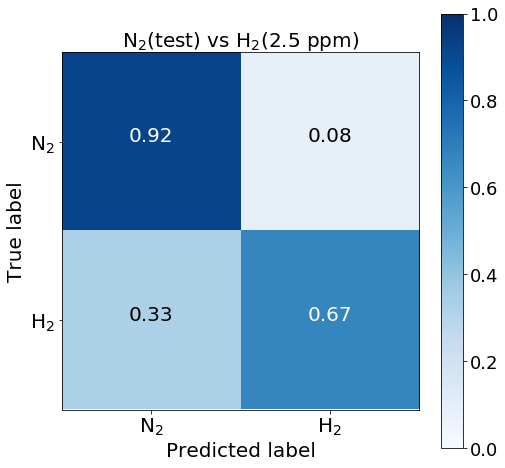

In [39]:
LABELS = ["N$_{2}$", "H$_{2}$"]
filename = './{}_figure_data/{}_RETYPE_confusion_matrix_N2_test_H2_2_5.png'.format(metal, metal)

data1 = normal_2_error_df.reconstruction_error.values
data2 = anomaly_1_df.reconstruction_error.values

data_all = np.concatenate([data1, data2])

thresholds = np.linspace(data_all.min(), data_all.max(), 100000)
scores = []
for temp_thres in tqdm(thresholds):
    y_pred = [1 if e > temp_thres else 0 for e in data_all]
    acc_score = accuracy_score(y_true, y_pred)
    pre_score = precision_score(y_true, y_pred)
    rec_score = recall_score(y_true, y_pred)
    temp_f1_score = f1_score(y_true, y_pred)

    scores.append([acc_score, pre_score, rec_score, temp_f1_score])

scores = np.array(scores)

## Calculate confusion matrix

final_thresh = thresholds[scores[:, 0].argmax()]

y_pred = [1 if e > final_thresh else 0 for e in data_all]

temp_acc = (accuracy_score(y_true, y_pred))
temp_pre = (precision_score(y_true, y_pred))
temp_rec = (recall_score(y_true, y_pred))
temp_f1 = (f1_score(y_true, y_pred))

# acc_total_2_5.append(temp_acc)
# pre_total_2_5.append(temp_pre)
# rec_total_2_5.append(temp_rec)
# f1_total_2_5.append(temp_f1)


# conf_matrix = confusion_matrix(y_true, y_pred)


print('#'*20, metal)
plt.figure(figsize=(10, 8))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=LABELS, title='N$_{2}$(test) vs H$_{2}$(2.5 ppm)', filename=filename)

In [40]:
print(temp_acc, temp_pre, temp_rec, temp_f1)

0.794 0.893048128342246 0.668 0.7643020594965675


100%|█████████▉| 99974/100000 [04:21<00:00, 409.40it/s]/home/youhanlee/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/youhanlee/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 100000/100000 [04:21<00:00, 382.81it/s]


#################### Pd1
Normalized confusion matrix


<Figure size 720x576 with 0 Axes>

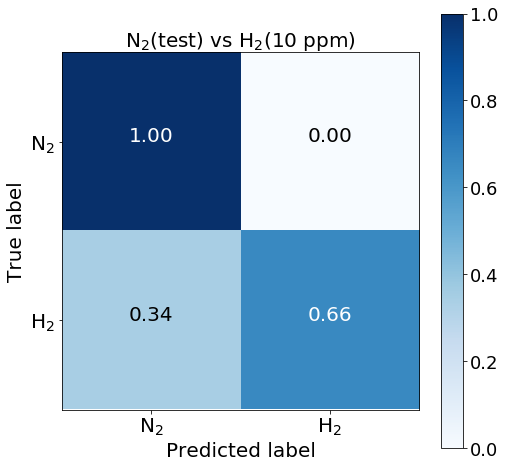

In [41]:
LABELS = ["N$_{2}$", "H$_{2}$"]
filename = './{}_figure_data/{}_RETYPE_confusion_matrix_N2_test_H2_10.png'.format(metal, metal)

data1 = normal_2_error_df.reconstruction_error.values
data2 = anomaly_2_df.reconstruction_error.values

data_all = np.concatenate([data1, data2])

thresholds = np.linspace(data_all.min(), data_all.max(), 100000)
scores = []
for temp_thres in tqdm(thresholds):
    y_pred = [1 if e > temp_thres else 0 for e in data_all]
    acc_score = accuracy_score(y_true, y_pred)
    pre_score = precision_score(y_true, y_pred)
    rec_score = recall_score(y_true, y_pred)
    temp_f1_score = f1_score(y_true, y_pred)

    scores.append([acc_score, pre_score, rec_score, temp_f1_score])

scores = np.array(scores)

## Calculate confusion matrix

final_thresh = thresholds[scores[:, 0].argmax()]

y_pred = [1 if e > final_thresh else 0 for e in data_all]

temp_acc = (accuracy_score(y_true, y_pred))
temp_pre = (precision_score(y_true, y_pred))
temp_rec = (recall_score(y_true, y_pred))
temp_f1 = (f1_score(y_true, y_pred))

# acc_total_2_5.append(temp_acc)
# pre_total_2_5.append(temp_pre)
# rec_total_2_5.append(temp_rec)
# f1_total_2_5.append(temp_f1)


# conf_matrix = confusion_matrix(y_true, y_pred)


print('#'*20, metal)
plt.figure(figsize=(10, 8))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=LABELS, title='N$_{2}$(test) vs H$_{2}$(10 ppm)', filename=filename)

In [42]:
print(temp_acc, temp_pre, temp_rec, temp_f1)

0.8285 0.995475113122172 0.66 0.7937462417318099


# Figure 5

In [43]:
def get_std_band_array(arrays):
    temp_std_array = []
    temp_bandwidth_array = []
    for temp_seq in arrays:
        temp_std = temp_seq.std()
        temp_bandwidth = temp_seq.max() - temp_seq.min()
        
        temp_std_array.append(temp_std)
        temp_bandwidth_array.append(temp_bandwidth)
    
    return np.array(temp_std_array), np.array(temp_bandwidth_array)


In [44]:
from sklearn.preprocessing import MinMaxScaler

n1_std_array, n1_bandwidth_array = get_std_band_array(normal_1)
n2_std_array, n2_bandwidth_array = get_std_band_array(normal_2)
a1_std_array, a1_bandwidth_array = get_std_band_array(anomaly_1)
a2_std_array, a2_bandwidth_array = get_std_band_array(anomaly_2)

In [46]:
total_std = np.concatenate([n1_std_array, n2_std_array, a1_std_array, a2_std_array])
scaler = MinMaxScaler()
total_std_scaled = scaler.fit_transform(total_std.reshape(-1, 1))

total_errors = error_df.reconstruction_error.values
scaler = MinMaxScaler()
total_errors_scaled = scaler.fit_transform(total_errors.reshape(-1, 1))

total_errors_scaled.min()

0.0

Text(0, 0.5, 'Normalized reconstruction error ')

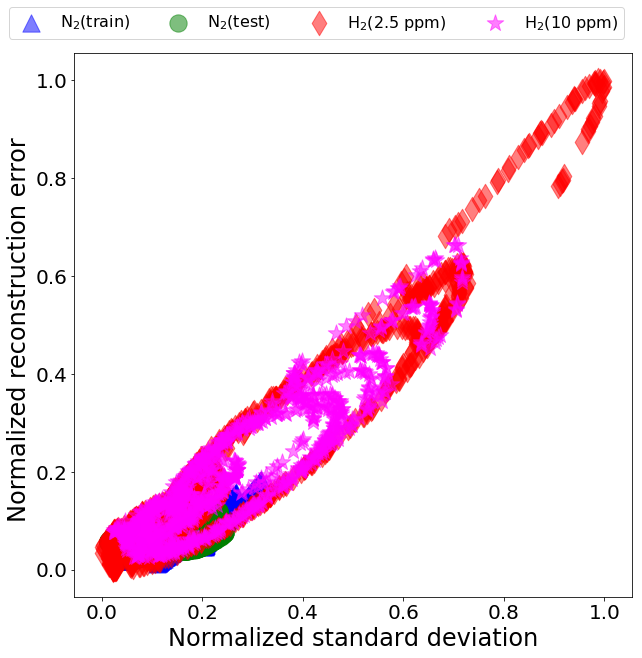

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
size = 300
# colormap = 'Oranges' 
# cmap = mpl.cm.spring
# norm = mpl.colors.Normalize(vmin=-0.1, vmax=1.1)


ax.scatter(total_std_scaled[:1000], total_errors_scaled[:1000], s=size, color='blue', marker='^', alpha=0.5)
ax.scatter(total_std_scaled[1000:2000], total_errors_scaled[1000:2000], s=size, color='green', marker='o', alpha=0.5)
ax.scatter(total_std_scaled[2000:3000], total_errors_scaled[2000:3000], s=size, color='red', marker='d', alpha=0.5)
ax.scatter(total_std_scaled[3000:4000], total_errors_scaled[3000:4000], s=size, color='magenta', marker='*', alpha=0.5)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.legend(['N$_{2}$(train)', 'N$_{2}$(test)', 'H$_{2}$(2.5 ppm)', 'H$_{2}$(10 ppm)'], loc='best', bbox_to_anchor=(1, 1.1), ncol=4, fontsize=16)
plt.xlabel('Normalized standard deviation', fontsize=24)
plt.ylabel('Normalized reconstruction error ', fontsize=24)